In [1]:
from utils import keys_to_counts, get_keys

In [2]:
import pandas as pd

data_path = "D:\\studium\\analyse\\data_prep\\src\\_2_preproc_pipeline_en\\data_preprocessed\\2_tokenize_eu_en.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,id,pub_year,text_preproc2
0,GB000002623832A,2024,arrangement electrosurgical instrument compris...
1,GB000002623831A,2024,arrangement electrosurgical instrument compris...
2,EP000004361921A1,2024,semantic automation builder process automation...
3,EP000004360823A1,2024,control method system provide system include c...
4,EP000004332716A3,2024,mapping object encountered garden tool include...


In [4]:
# vectorize the text data with tf-idf
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=10, max_df=0.9)

x_vec = vectorizer.fit_transform(df['text_preproc2'])

In [5]:
vectorizer.get_feature_names_out().__len__()

1365

In [6]:
"roboter" in set(vectorizer.get_feature_names_out())

False

In [7]:
# Define Search Param
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


search_params = {
    'n_components': list([6, 8]),
    'learning_decay': [i/10 for i in range(2, 8, 2)]
}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50., random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(x_vec)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.2, 0.4, 0.6],
                         'n_components': [6, 8]})

In [8]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(x_vec))

Best Model's Params:  {'learning_decay': 0.6, 'n_components': 6}
Best Log Likelihood Score:  -232008.0205167792
Model Perplexity:  430.9775390277455


#### 1
```
Best Model's Params:  {'learning_decay': 0.6, 'n_components': 6}
Best Log Likelihood Score:  -232008.0205167792
Model Perplexity:  430.9775390277455

tfidf = CountVec(min_df=10, max_df=0.9)
```

In [9]:
lda_output = best_lda_model.transform(x_vec)

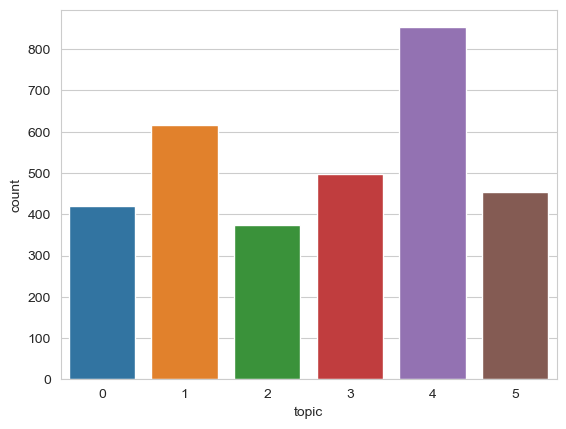

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

lda_keys = get_keys(lda_output)
lda_categories, lda_counts = keys_to_counts(lda_keys)

topics_df_lda = pd.DataFrame({'topic' : lda_categories, 'count' : lda_counts})
sns.barplot(x=topics_df_lda['topic'], y = topics_df_lda['count'])
plt.show()

In [11]:
import numpy as np

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,method,control,device,storage,target,system,container,object,position,apparatus,information,point,unit,motion,accord
Topic 1,method,mobile,system,datum,sensor,object,base,comprise,determine,autonomous,environment,map,detection,detect,present
Topic 2,system,tool,position,configure,device,comprise,image,unit,work,station,charge,workpiece,include,base,camera
Topic 3,body,device,cleaning,include,surface,drive,provide,clean,unit,plate,comprise,housing,motor,cooking,portion
Topic 4,arm,end,second,comprise,surgical,drive,instrument,assembly,portion,system,element,configure,joint,axis,member
Topic 5,control,device,system,operation,information,include,method,user,datum,configure,unit,controller,base,signal,receive


In [12]:
#this is by far the easiest way to load a pre-trained sklearn lda model onto pyLDAvis
#there are other means of using this visible on pyLDAvis' main repo

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

feature_names = vectorizer.get_feature_names_out()

vectorizer.get_feature_names = lambda: feature_names

display_data = pyLDAvis.sklearn.prepare(best_lda_model, #our pre-trained LDA model
                         x_vec, #this gives us our document-term matrix
                        vectorizer) #the vectoriser object
                        
pyLDAvis.display(display_data)  

C:\Users\paul-\anaconda3\envs\ml_angew_programm\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
